## Random Variable Infrastructure
### Basics

Distributions (or, more accurately, distribution families) are classes named according to `CamelCase` conventions. They must be instantiated before use, with parameters passed as keyword-only arguments.
*Instances* of the distribution classes can be thought of as random variables, which are commonly denoted in mathematics using capital letters.

In [1]:
from scipy import stats
X = stats.LogUniform(a=1, b=2)
X

LogUniform(a, b)

In [2]:
X.support()

(1.0, 2.0)

Distributions can support multiple parameterizations. For instance, it is also natural to parameterize the log-uniform distribution using the logarithms of the support endpoints. (If a log-uniform random variable is supported on $[a, b]$, its logarithm follows a uniform distribution with support $[\log(a), \log(b)$].)

In [3]:
import numpy as np
Y = stats.LogUniform(log_a=np.log(1), log_b=np.log(2))
Y

LogUniform(log_a, log_b)

After being defined, these two random variables are essentially equivalent. As a weak example:

In [4]:
X.support() == Y.support()

True

All parameters of the distribution underlying the random variable are available as attributes.

In [5]:
X.a, X.b, X.log_a, X.log_b

(1.0, 2.0, 0.0, 0.6931471805599453)

Currently, there is an `update_parameters` method that changes the parameters of the distribution underlying an existing random variable. We have discussed the possibility of overriding `__setattr__` for this purpose, but there are downsides.

In [6]:
X.update_parameters(a=0.5)
X.support()

(0.5, 2.0)

### Defining a distribution

Minimal information is needed to fully define a distribution class. For example, a class representing a uniform distribution parameterized by the lower and upper ends of the support might look like this.

In [7]:
from scipy.stats._distribution_infrastructure import (ContinuousDistribution, _RealDomain,
                                                      _RealParameter, _Parameterization, oo)

class UniformDistribution(ContinuousDistribution):
    _a_param = _RealParameter('a', domain=_RealDomain(endpoints=(-oo, oo)))
    _b_param = _RealParameter('b', domain=_RealDomain(endpoints=('a', oo)))
    _x_param = _RealParameter('x', domain=_RealDomain(endpoints=('a', 'b'), inclusive=(True, True)))

    _parameterizations = [_Parameterization(_a_param, _b_param)]
    _variable = _x_param

    def _pdf_formula(self, x, *, a, b, **kwargs):
        return np.ones_like(x)/(b-a)

The infrastructure automatically validates numerical distribution parameters and method arguments based on their abstract definitions.

In [8]:
a, b = 1, 3
X = UniformDistribution(a=a, b=b)
x = np.arange(a - 0.5, b + 0.51, 0.5)

In [9]:
X.support()

(1.0, 3.0)

In [10]:
X.pdf(x)

array([0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0. ])

In [11]:
X.cdf(x)

array([0.  , 0.  , 0.25, 0.5 , 0.75, 1.  , 1.  ])

In [12]:
X.icdf([-0.5, 0.5, 1.5])  # there are no numbers for which the CDF is negative or greater than 1

array([nan,  2., nan])

Rather than raising errors, out-of-domain shapes and NaNs result in methods returning NaNs. This allows for valid calculations to proceed normally.

In [13]:
X = UniformDistribution(a=[[b], [a], [np.nan]], b=[[a], [b], [np.nan]])  # recall that the domain of b is (a, oo)
X.pdf(x)

array([[nan, nan, nan, nan, nan, nan, nan],
       [0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0. ],
       [nan, nan, nan, nan, nan, nan, nan]])

### Transformations

Transformations can be applied to random variables. For instance, shifted and scaled versions can be created using `ShiftedScaledDistribution`.

In [14]:
x = 1.
loc = np.asarray([1, 2, 3])
scale = np.asarray([2, 3])[:, np.newaxis]
X = stats.Normal()
Y = stats.ShiftedScaledDistribution(X, loc=loc, scale=scale)
np.testing.assert_equal(Y.cdf(x), X.cdf((x-loc)/scale))

 There are several advantages of this architecture compared to building transformations directly into the `ContinuousDistribution` class:
- It allows distributions to use common parameterizations. By contrast, `rv_continuous` requires parameterizations to consider `loc` and `scale` or risk overparameterization. For example,
  - `stats.uniform` does not allow parameterization with the left and right support endpoints; it only accepts `loc` and `scale`.
  - `stats.loguniform` accepts the left and right support endpoints as shape parameters `a` and `b`; consequently, `a`, `b`, and `scale` are not independent parameters.
- Any overhead associated with a transformation is avoided unless the transformation is intentionally applied. (Although this is possible to achieve even if the transformation capabilities are built into the class, it may require special care.)
- It is highly extensible. For instance, transformations can also be used to generically define:
  - truncated distributions
  - half/double distributions
  - wrapped distributions
  - order statistic distributions
  - $\log$/$\exp$ transformed distributions

  and these can be applied in any order.
- It avoids common pitfalls when fitting distributions to data. For instance, in the current infrastructure:
  - Users often forget to fix the location of distributions which almost always have fixed locations. This often results in poor fits or unexpected values of fit parameters.
  - It is impossible to fix the truncation points of truncated distributions because the loc-scale transformation is applied *after* the shape parameters truncate the support. It is more naturable to use the distribution if the these transformations are applied in the opposite order.

Shifted/scaled distributions support basic arithmetic operations with arrays.

In [15]:
Y = stats.ShiftedScaledDistribution(X, loc=0, scale=1)
Y = Y*scale + loc
Y

Normal(loc, scale, shape=(2, 3))

In [16]:
Y.loc, Y.scale

(array([[1., 2., 3.],
        [1., 2., 3.]]),
 array([[2., 2., 2.],
        [3., 3., 3.]]))

In [17]:
np.testing.assert_equal(Y.cdf(x), X.cdf((x-loc)/scale))

Negative scale (multiplication by negative values) is supported. This eliminates the need to have separate flipped distributions (e.g. `gumbel_l`/`gumbel_r`).

In [18]:
X = stats.LogUniform(a=1, b=2)
Y = stats.ShiftedScaledDistribution(X, loc=0, scale=-1)
X.support(), Y.support()

((1.0, 2.0), (-2.0, -1.0))

### Performance
#### Overhead
I've been careful to reduce overhead where possible.

In [19]:
x = 1.
X = stats.Normal()
%timeit X.pdf(x)

6.23 µs ± 382 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [20]:
dist = stats.norm()  # old infrastructure
%timeit dist.pdf(x)

73.2 µs ± 2.36 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Even though these are meant to be instantiated once and used many times, instantiation followed by use is still usually faster than the old infrastructure.

In [21]:
%timeit stats.Normal().pdf(x)  # new infrastructure

13.6 µs ± 917 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [22]:
%timeit stats.norm.pdf(x)  # old infrastructure

71.8 µs ± 883 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


If there's still too much overhead, the user can disable input validation.

In [23]:
X = stats.Normal(iv_policy='skip_all')
%timeit X.pdf(x)

2.06 µs ± 7.71 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [24]:
%timeit stats.Normal(iv_policy='skip_all').pdf(x)

6.43 µs ± 57.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Overhead increases when shape parameters are invalid, need to be broadcast, or need to be converted to a floating point type for calculations. In these cases, there has been substantial effort to keep the overhead low and provide performance comparable to or better than `rv_continuous`.

#### Numerical calculations
Another important aspect of performance is that of methods for which analytical formulas are not available. For example, the Gauss hypergeometric distribution can be defined as follows.

In [25]:
from scipy.stats._distribution_infrastructure import (ContinuousDistribution, _RealDomain,
                                                      _RealParameter, _Parameterization, oo)
from scipy import special

class GaussHyper(ContinuousDistribution):
    """Gauss hypergeometric distribution"""

    _a_param = _RealParameter('a', domain=_RealDomain(endpoints=(0, oo)))
    _b_param = _RealParameter('b', domain=_RealDomain(endpoints=(0, oo)))
    _c_param = _RealParameter('c', domain=_RealDomain(endpoints=(-oo, oo)))
    _z_param = _RealParameter('z', domain=_RealDomain(endpoints=(-1, oo)))
    _x_param = _RealParameter('x', domain=_RealDomain(endpoints=(0, 1), inclusive=(True, True)))

    _parameterizations = [_Parameterization(_a_param, _b_param, _c_param, _z_param)]
    _variable = _x_param

    def _pdf_formula(self, x, *, a, b, c, z, **kwargs):
        Cinv = special.gamma(a) * special.gamma(b) / special.gamma(a + b) * special.hyp2f1(c, a, a + b, -z)
        return 1.0 / Cinv * x ** (a - 1.0) * (1.0 - x) ** (b - 1.0) / (1.0 + z * x) ** c

a, b, c, z = 1.5, 2.5, 2, 0
X = GaussHyper(a=a, b=b, c=c, z=z)
x = 0.5

For scalar shapes and argument, performance of the new and old infrastructures are comparable.

In [26]:
%timeit X.cdf(x)  # new infrastructure

866 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
%timeit stats.gausshyper.cdf(x, a, b, c, z)  # old infrastructure

912 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
%timeit X.icdf(x)  # new infrastructure

10.2 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%timeit stats.gausshyper.ppf(x, a, b, c, z)  # old infrastructure

7.44 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
np.testing.assert_allclose(X.cdf(x), stats.gausshyper.cdf(x, a, b, c, z))
np.testing.assert_allclose(X.icdf(x), stats.gausshyper.ppf(x, a, b, c, z))

But the quadrature and rootfinding code of the new infrastructure is vectorized (and eventually will be Array-API compatible), so it is much faster when arrays are involved.

In [31]:
x = np.linspace(0, 1, 1000)

In [32]:
%timeit X.cdf(x)  # new infrastructure

5.84 ms ± 71.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%timeit stats.gausshyper.cdf(x, a, b, c, z)  # old infrastructure

810 ms ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit X.icdf(x)  # new infrastructure

76.8 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
# Warning: takes a long time
%timeit stats.gausshyper.ppf(x, a, b, c, z)  # old infrastructure

7.59 s ± 87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There are plans for the new infrastructure to use interpolation for additional performance gains with very large arrays.

### Distribution properties
There new infrastructure has the distribution "properties" one would expect. `mode`, `skewness`, `kurtosis`, and `logentropy` are new.

In [36]:
X = stats.Normal()
X.mean(), X.median(), X.mode()

(0.0, 0.0, 0.0)

In [37]:
X.std(), X.var()

(1.0, 1.0)

In [38]:
X.skewness(), X.kurtosis()  # *Pearson* kurtosis

(0.0, 3.0)

In [39]:
X.entropy(), X.logentropy()

(1.4189385332046727, (0.34990908025919965+0j))

Note that the `logentropy` method returns a complex value because the entropy can be negative. The logarithm of a negative number is the logarithm of the number's magnitude plus an odd multiple of $\pi i$.

In [40]:
Y = stats.LogUniform(a=1, b=2)
Y.entropy(), Y.logentropy()

(-0.019939330301691684, (-3.9150611006848894+3.141592653589793j))

These are implemented as methods rather than `@property`s because they accept arguments. For instance, the entropy can be computed using the analytical formula, by exponentiating the log-entropy, or by quadrature.

In [41]:
X.entropy(), X.entropy(method='logexp'), X.entropy(method='quadrature')

(1.4189385332046727, 1.4189385332046727, 1.4189385332046731)

### Distribution functions
Functions of the distributions underlying the random variables follow a consistent naming scheme.
- prefix `i` is for "inverse"
- prefix `c` is for "complementary"
- prefix `log` is for "logarithm of"

In [42]:
x = 1.
np.testing.assert_allclose(X.icdf(X.cdf(x)), x)
np.testing.assert_allclose(X.iccdf(X.ccdf(x)), x)
np.testing.assert_allclose(X.ilogcdf(X.logcdf(x)), x)
np.testing.assert_allclose(X.ilogccdf(X.logccdf(x)), x)

Note the addition of new methods for the inverse of the logarithm of distribution functions. These are useful when the argument of `icdf` would be too small or too close to `1.0` to represent accurately using floating point numbers.

In [43]:
np.testing.assert_allclose(X.ilogcdf(X.logcdf(-1000.)), -1000)
np.testing.assert_allclose(X.ilogccdf(X.logccdf(1000.)), 1000)

The distribution methods also have two-argument versions.

In [44]:
x1, x2 = 1., 2.
np.testing.assert_allclose(X.cdf(x1, x2),
                           X.cdf(x2) - X.cdf(x1))
np.testing.assert_allclose(X.ccdf(x1, x2),
                           1 - X.cdf(x1, x2))
np.testing.assert_allclose(X.logcdf(x1, x2),
                           np.log(X.cdf(x1, x2)))
np.testing.assert_allclose(X.logccdf(x1, x2),
                           np.log(X.ccdf(x1, x2)))

Besides convenience, this avoids catastropic cancellation where possible.

In [45]:
x1, x2 = 20., 20.5
X.cdf(20, 20.5), X.cdf(x2) - X.cdf(x1)

(2.7535164718735247e-89, 0.0)

For numerically challenging cases, there are alternative `method` options available.

In [46]:
eps = 1e-100
res = X.logcdf(0., eps, method='quadrature')
ref = X.logpdf(0.) + np.log(eps)
np.testing.assert_equal(res, ref)

All distribution functions from the old distribution infrastructure are available in the new infrastructure (albeit under different names) with the following exceptions.
- `interval` is not avaialable as a separate method, but the same values can be calculated using `iccdf` and `icdf`. However, the probability interval is in some sense an inverse of the two-argument `cdf`, so we could consider adding the capabilities to `icdf`.
- `expect` will not be supported. In the old infrastructure, this was little more than a light wrapper around an integrator, and we cannot do much better in general cases. The bug report to convenience ratio was too unfavorable to justify inclusion in the new infrastructure.

### Random Sampling
Technically, "observe" might be a better name for this method, since instances like `X` represent a random variable. In any case, `sample` is easier to interpret than `rvs`:

In [47]:
X.sample()

-1.6043549064307483

Currently, a Generator can be passed either during construction or when calling the `sample` method.

In [48]:
rng = np.random.default_rng(872438745698345)
X = stats.Normal(rng=rng)
sample1 = X.sample()

rng2 = np.random.default_rng(872438745698345)
sample2 = X.sample(rng=rng2)

np.testing.assert_equal(sample1, sample2)

The parameter that controls the shape of the sample is called `shape`.

In [49]:
X.sample(shape=(2, 3))

array([[-0.52931289,  0.88922355,  0.1664083 ],
       [ 0.39524223,  0.30158984, -0.87769806]])

`QMCEngine`s can also be used. Each slice along the last axis is generated from an independent low-discrepancy sequence.

In [50]:
qrng = stats.qmc.Halton
n_observations = 10000
sample1 = X.sample(shape=(n_observations,), qmc_engine=qrng)
# Verify a property we would expect to hold exactly
np.testing.assert_equal((sample1 > 0).sum(), n_observations/2)

An important change is that the user does not need to consider the shape of the distribution parameters when specifying the `shape` of the sample.

In [51]:
n_observations = 4
X_temp = stats.LogUniform(a=[0.5, 0.9],
                          b=[[1], [2], [3]])
sample = X_temp.sample(shape=n_observations)
sample.shape == (n_observations,) + X_temp._shape

True

### Moments
There are separate methods for calculating the raw, central, and standard moments of any order.

In [52]:
np.testing.assert_equal(X.moment_raw(order=1),
                        X.mean())
np.testing.assert_equal(X.moment_central(order=2),
                        X.var())
np.testing.assert_equal(X.moment_standard(order=3),
                        X.skewness())

X.moment_standard(order=10)

944.9999999999995

We can consider consolidating these into one method, `moment`, but there are some interface questions to answer.

An obvious option would be for `moment` to accept
 - `center`, the value about which to center the moment (e.g. `0` for a raw moment), and
 - `standardize`, a Boolean to control whether the moment is standardized.

 However, this leads to the possibility of the user passing a `center` that is not the mean yet attempting to `standardize` the moment. This would be unusual.

Another reason that separate methods may be preferred is that the default behavior is unambiguous. It is most common to use the raw first moment (mean), central second moment (variance), and standardized higher moments (e.g. skewness and kurtosis). With that in mind, what should `moment(order=1), moment(order=2), moment(order=3)` return?

### Fitting
There is a very rough draft of a generalized `fit` method. The method would unify techniques like maximum likelihood estimation with other needs, such as inverting distribution functions with respect to distribution parameters. We begin by initializing a normal distribution.

In [60]:
from scipy.stats._new_distributions import ShiftedScaledNormal
X = ShiftedScaledNormal(loc=0, scale=1)

Suppose we know the desired mean and standard deviation and wish to fit the `loc` and `scale` parameters of the distribution to achieve them.

In [62]:
X.fit([X.mean, X.std], 
      output=[1, 2],
      parameters=['loc', 'scale'])
print(X.mean(), X.std())

1.0 2.0


Or if we know the desired values of the `pdf` and `cdf` when the argument is `0`:

In [65]:
X.fit([lambda: X.pdf(0), lambda: X.cdf(0)], 
       output=[0.5, 0.35],
       parameters=['loc', 'scale'])
X.pdf(0), X.cdf(0)

(0.5, 0.35)

Of course, we can still perform maximum likelihood optimization.

In [66]:
X.fit(lambda: X.llf(sample=[1, 2, 3]), 
      output='maximize',
      parameters=['loc', 'scale'])
X.loc, X.scale

(2.0000000004810885, 0.8164965381232903)

### Convenience functions
Currently there is a convenience function for plotting. I like the idea of it, but it's in a draft state.


<Axes: title={'center': 'Normal(loc, scale, shape=(3,))'}, xlabel='x'>

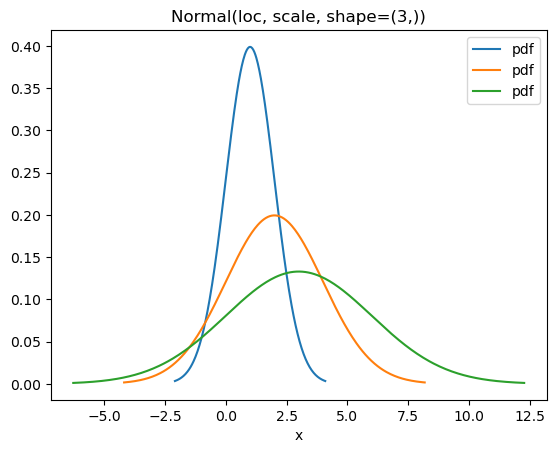

In [53]:
X = stats.ShiftedScaledNormal(loc=[1, 2, 3], scale=[1, 2, 3])
X.plot()

<Axes: title={'center': 'Normal(loc, scale, shape=(3,))'}, xlabel='x'>

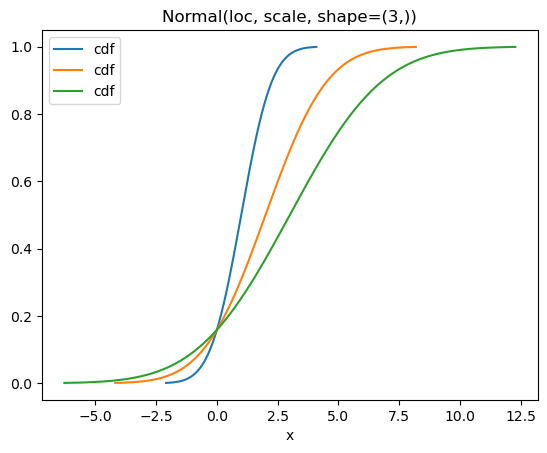

In [54]:
X.plot(func='cdf')

<Axes: title={'center': 'Normal(loc, scale, shape=(3,))'}, xlabel='x'>

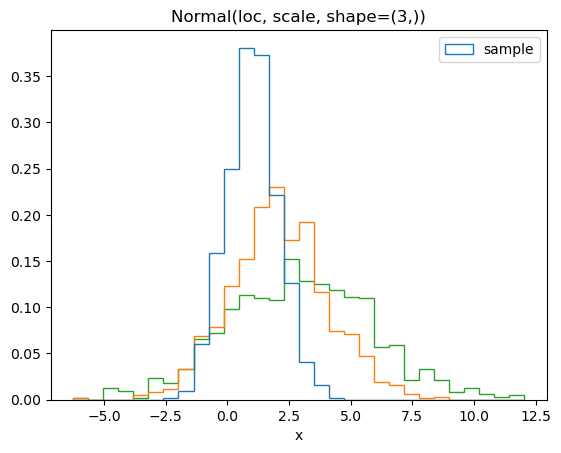

In [55]:
X.plot(func='sample')

### Order statistics distributions
There is draft support for distributions of [order statistics](https://en.wikipedia.org/wiki/Order_statistic) of distributions, partially to demonstrate the flexibility of distribution transformations. For example, we can plot the probability density functions of the order statistics of a normal distribution with sample size 4.

<Axes: title={'center': 'Normal(n, r, shape=(4,))'}, xlabel='x'>

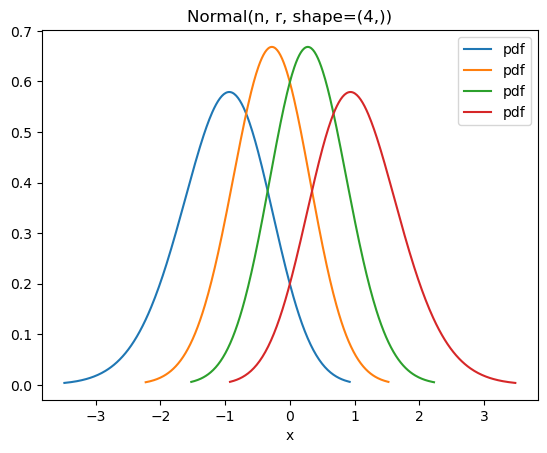

In [56]:
from scipy.stats._new_distributions import OrderStatisticDistribution
n = 4
r = np.arange(1, n+1)
X = stats.Normal()
Y = OrderStatisticDistribution(X, r=r, n=n)
Y.plot()

Compute the expected values of these order statistics.

In [57]:
Y.mean()

array([-1.02937537, -0.29701138,  0.29701138,  1.02937537])

The `OrderStatisticDistribution` can be shifted and scaled, or we can generate an `OrderStatsticDistribution` from a shifted and scaled distribution. (In this case, the order of operations doesn't matter, but that is not the case for all transformations.)

In [58]:
loc, scale= 1, 2
Y1 = stats.ShiftedScaledDistribution(OrderStatisticDistribution(stats.Normal(), r=r, n=n), loc=loc, scale=scale)
Y2 = OrderStatisticDistribution(stats.ShiftedScaledDistribution(stats.Normal(), loc=loc, scale=scale), r=r, n=n)
np.testing.assert_allclose(Y1.mean(), Y.mean()*scale+loc)
np.testing.assert_allclose(Y2.mean(), Y.mean()*scale+loc)